In [ ]:
cd drive/My\ Drive/first_impressions_data

/content/drive/My Drive/first_impressions_data


In [ ]:
cd transcriptions/

/content/drive/My Drive/first_impressions_data/transcriptions


# Imports

In [ ]:
import pandas as pd
import numpy as np
import nltk
import random
from nltk.classify.scikitlearn import SklearnClassifier
import pickle
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import SVC
from nltk.classify import ClassifierI
from statistics import mode
from nltk.tokenize import word_tokenize
import re
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.svm import SVR

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
training_df = pd.read_csv('training_screened_df.csv')
validation_df = pd.read_csv('validation_screened_df.csv')
test_df = pd.read_csv('test_screened_df.csv')
mit_df = pd.read_csv('mit_full_transcripts.csv')

In [ ]:
test_df.shape

(998, 8)

In [ ]:
training_data = training_df[['transcript', 'interview', 'openness', 'conscientiousness', 'extraversion', 'agreeableness', 'neuroticism']].values
validation_data = validation_df[['transcript', 'interview', 'openness', 'conscientiousness', 'extraversion', 'agreeableness', 'neuroticism']].values
test_data = test_df[['transcript', 'interview', 'openness', 'conscientiousness', 'extraversion', 'agreeableness', 'neuroticism']].values
mit_data = mit_df[['answers', 'RecommendHiring']].values

# Building the final DT and SVC regressors

In [ ]:
training_iocean = training_data[:, 1:]
validation_iocean = validation_data[:, 1:]
test_iocean = test_data[:, 1:]

In [ ]:
final_training_iocean = np.concatenate((training_iocean, validation_iocean), axis = 0)

final_training_iocean.shape

(4009, 6)

In [ ]:
final_regr = DecisionTreeRegressor(min_samples_split=3, max_depth=3, random_state=0,  max_features=3)
final_regr.fit(final_training_iocean[:, 1:], final_training_iocean[:, 0])

training_preds = final_regr.predict(final_training_iocean[:, 1:])
test_preds = final_regr.predict(test_iocean[:, 1:])

training_score = 1 - mean_absolute_error(final_training_iocean[:, 0], training_preds)
test_score = 1 - mean_absolute_error(test_iocean[:, 0], test_preds)

print(training_score)
print(test_score)

0.9544594517116215
0.9552252760571104


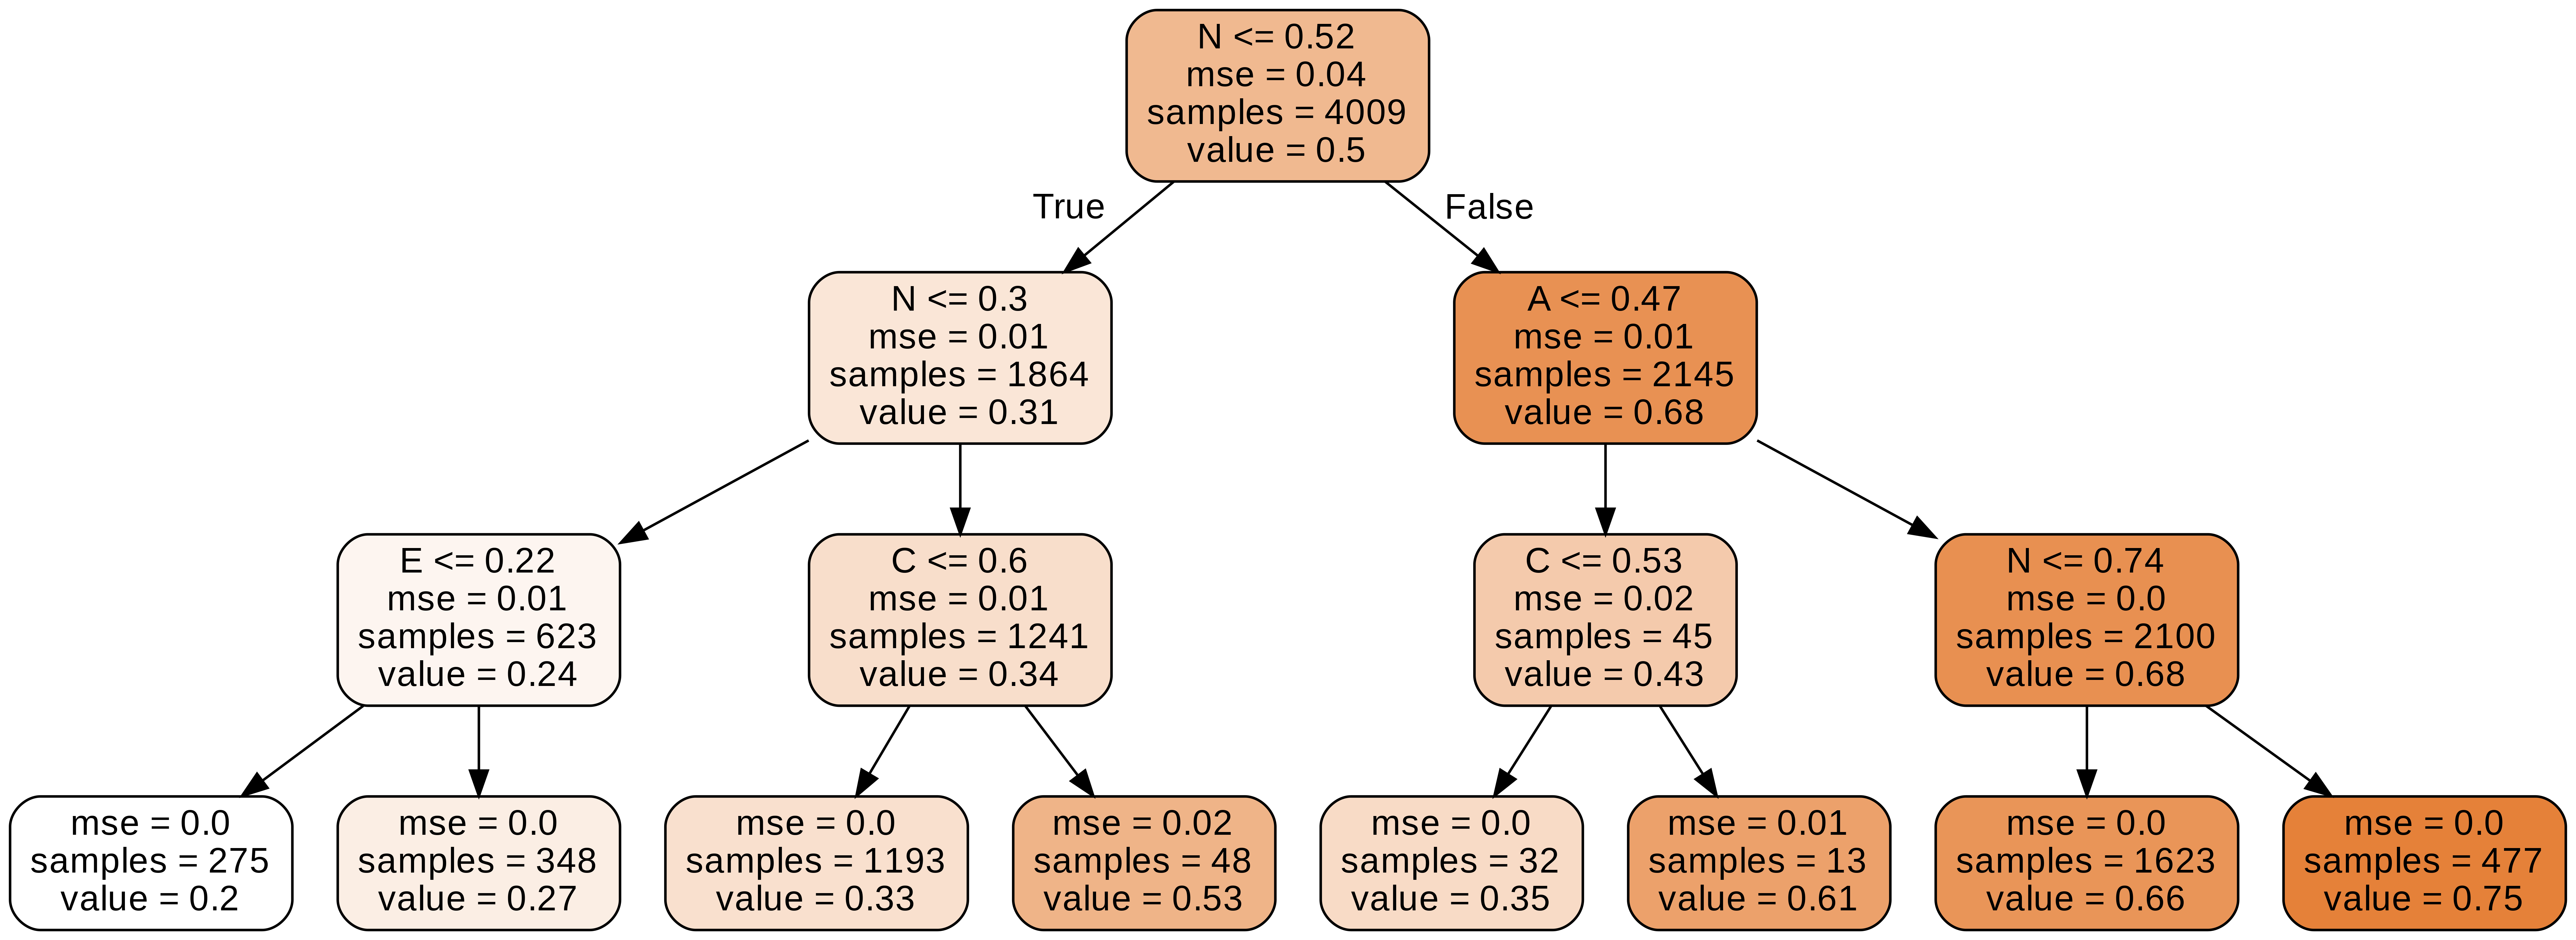

In [ ]:
from sklearn.tree import export_graphviz

feature_names = ['O', 'C', 'E', 'A', 'N']
# Export as dot file
export_graphviz(final_regr, out_file='tree-full-ternary.dot', 
                feature_names = feature_names,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

from subprocess import call
call(['dot', '-Tpng', 'tree-full-ternary.dot', '-o', 'tree-full-ternary.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree-full-ternary.png')

# Cleaning text

In [ ]:
del_index = []
for i in range(len(training_data)):
  if not isinstance(training_data[i, 0], str):
    del_index.append(i)

training_data = np.delete(training_data, del_index, axis = 0)
print(len(del_index))

del_index = []
for i in range(len(test_data)):
  if not isinstance(test_data[i, 0], str):
    del_index.append(i)

test_data = np.delete(test_data, del_index, axis = 0)
print(len(del_index))

5
3


In [ ]:
print(len(training_data))
print(len(validation_data))
print(len(test_data))
print(len(mit_data))

print(training_data[0])
print(validation_data[0])
print(test_data[0])

complete_data = np.concatenate((training_data, validation_data), axis = 0)
complete_data = np.concatenate((complete_data, test_data), axis = 0)

print(complete_data.shape)

3037
967
995
138
['We will. I always get the nice pillow.' 0.7102803738317757
 0.6222222222222222 0.6601941747572816 0.663551401869159
 0.7032967032967032 0.6979166666666666]
["What is your favorite [sport 00:30] and why? And another one is do you ... I'll do the second question afterwards. So sports do I play. I played ... Now in my time, before I did YouTube, before I ended up-"
 0.616822429906542 0.5555555555555556 0.6407766990291262
 0.6448598130841123 0.6153846153846153 0.59375]
["... Going nuts from another room, run in there to check, there's no [inaudible 00:00:37], but it was like the [scissors 00:00:35] aren't there. Now maybe I'm just not sleeping enough that I moved the scissors somewhere, but I swear the-"
 0.6261682242990654 0.8222222222222221 0.6699029126213591
 0.485981308411215 0.6813186813186812 0.6458333333333333]
(4999, 7)


In [ ]:
all_words = []
documents = []

from nltk.corpus import stopwords
import re

stop_words = list(set(stopwords.words('english')))
stop_words.append('inaudible')
stop_words.append('du')

#  j is adject, r is adverb, and v is verb
#allowed_word_types = ["J","R","V"]
allowed_word_types = ["J", "V","R", "N"]

k = 0

for p in complete_data:
    
    # create a list of tuples where the first element of each tuple is a review
    # the second element is the label
    
    # remove punctuations

    p[0] = p[0].lower()

    cleaned = re.sub(r'[^(a-zA-Z)\s]','', p[0])
    
    # tokenize 
    tokenized = word_tokenize(cleaned)
    
    # remove stopwords 
    stopped = [w for w in tokenized if not w in stop_words]
    
    # parts of speech tagging for each word 
    part_of_speech = nltk.pos_tag(stopped)
    
    # make a list of  all adjectives identified by the allowed word types list above
    for w in part_of_speech:
        if w[1][0] in allowed_word_types:
            all_words.append(w[0].lower())

for p in mit_data:
    
    # create a list of tuples where the first element of each tuple is a review
    # the second element is the label
    
    # remove punctuations

    p[0] = p[0].lower()

    cleaned = re.sub(r'[^(a-zA-Z)\s]','', p[0])
    
    # tokenize 
    tokenized = word_tokenize(cleaned)
    
    # remove stopwords 
    stopped = [w for w in tokenized if not w in stop_words]
    
    # parts of speech tagging for each word 
    part_of_speech = nltk.pos_tag(stopped)
    
    # make a list of  all adjectives identified by the allowed word types list above
    for w in part_of_speech:
        if w[1][0] in allowed_word_types:
            all_words.append(w[0].lower())

In [ ]:
print(complete_data)

[['we will. i always get the nice pillow.' 0.7102803738317757
  0.6222222222222222 ... 0.663551401869159 0.7032967032967032
  0.6979166666666666]
 ['last name, what would you change it to? this is a funny question, because when i was in school, i actually used to change my name all the time. my teachers used to really tell me off for it because they\'d go through, and they\'d be like, "tanya, we can\'t find your work." then, they\'d be like, "oh, now we found it. you just changed your name."'
  0.6355140186915886 0.7 ... 0.6074766355140188 0.5714285714285714
  0.6666666666666667]
 ["i don't think our generation, marriage is a must. i think that's fallen by the wayside. an example of myself and my girlfriend. we've been together for three years, a great relationship. we don't argue. we don't fight. we enjoy each other still to this day after four years ..."
  0.644859813084112 0.6333333333333333 ... 0.37383177570093457
  0.6043956043956044 0.5833333333333333]
 ...
 ["personally, i've le

In [ ]:
BOW = nltk.FreqDist(all_words)
word_features = list(BOW.keys())[:5000]
word_features[0], word_features[-1]

('always', 'spending')

In [ ]:
save_word_features = open("word_features5k.pickle","wb")
pickle.dump(word_features, save_word_features)
save_word_features.close()

In [ ]:
def find_features(document):
    words = word_tokenize(document)
    features = np.zeros(5000)
    for i in range(5000):
        if word_features[i] in words:
          features[i] = 1

    return features

# Creating features for each review
featuresets = [(find_features(rev)) for (rev, i, o, c, e, a, n) in complete_data]
mitfeatures = [(find_features(rev)) for (rev, i) in mit_data]

featuresets = np.array(featuresets)
mitfeatures = np.array(mitfeatures)
 
print(featuresets.shape)
print(mitfeatures.shape)

(4999, 5000)
(138, 5000)


In [ ]:
print(sum(mitfeatures[0]))

120.0


In [ ]:
import random
training_set = featuresets[:4004]
training_set = np.concatenate((training_set, mitfeatures[:100]), axis = 0)
# training_set = mitfeatures[:100]
testing_set = mitfeatures[100:] #featuresets[4004:]
print( 'training_set :', len(training_set), '\ntesting_set :', len(testing_set))

training_set : 4104 
testing_set : 38


In [ ]:
training_labels = complete_data[:4004, 1].reshape(-1,1)
training_labels = np.concatenate((training_labels, mit_data[:100, 1].reshape(-1,1)), axis = 0)
# training_labels = mit_data[:100, 1].reshape(-1,1)
testing_labels = mit_data[100:, 1].reshape(-1,1)#complete_data[4004:, 1:7]


print(len(training_labels))
print(testing_labels.shape)

4104
(38, 1)


In [ ]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [ ]:
training_set, training_labels = unison_shuffled_copies(training_set, training_labels)
testing_set, testing_labels = unison_shuffled_copies(testing_set, testing_labels)

In [ ]:
final_training_preds = np.zeros((4004, 5))
final_training_int = np.zeros(4004)

final_test_preds = np.zeros((995, 5))
final_test_int = np.zeros(995)

# Interview

In [ ]:
reg = RandomForestRegressor(max_depth = 10)
reg.fit(training_set, training_labels[:, 0])

training_preds = reg.predict(training_set)
testing_preds = reg.predict(testing_set)

print("MAX DEPTH " + str(10))
print("Training score " + str(1-mean_absolute_error(training_labels[:, 0], training_preds)))
print("Testing score " + str(1-mean_absolute_error(testing_labels[:, 0], testing_preds)))
print("----------------------------------------------")

MAX DEPTH 10
Training score 0.8304486600944957
Testing score 0.8873795351587411
----------------------------------------------


In [ ]:
reg = SVR(C = 0.1)
reg.fit(training_set, training_labels[:, 0])

training_preds = reg.predict(training_set)
testing_preds = reg.predict(testing_set)

print("Training score " + str(1-mean_absolute_error(training_labels[:, 0], training_preds)))
print("Testing score " + str(1-mean_absolute_error(testing_labels[:, 0], testing_preds)))
print("----------------------------------------------")

Training score 0.8786069996706364
Testing score 0.8830363290085333
----------------------------------------------


In [ ]:
final_training_int = training_preds
final_test_int = testing_preds

Only FICS :- 
RF = 81.67
SVM = 87.00

Only FICS :- 
RF = 89.80
SVM = 88.30

# Openness

In [ ]:
reg = RandomForestRegressor(max_depth = 10)
reg.fit(training_set, training_labels[:, 1])

training_preds = reg.predict(training_set)
testing_preds = reg.predict(testing_set)

print("MAX DEPTH " + str(10))
print("Training score " + str(1-mean_absolute_error(training_labels[:, 1], training_preds)))
print("Testing score " + str(1-mean_absolute_error(testing_labels[:, 1], testing_preds)))
print("----------------------------------------------")

MAX DEPTH 10
Training score 0.8604043088291612
Testing score 0.8517419660328783
----------------------------------------------


In [ ]:
reg = SVR(C = 0.1)
reg.fit(training_set, training_labels[:, 1])

training_preds = reg.predict(training_set)
testing_preds = reg.predict(testing_set)

print("Training score " + str(1-mean_absolute_error(training_labels[:, 1], training_preds)))
print("Testing score " + str(1-mean_absolute_error(testing_labels[:, 1], testing_preds)))
print("----------------------------------------------")

Training score 0.8960135038997945
Testing score 0.8626817909654262
----------------------------------------------


In [ ]:
final_training_preds[:, 0] = training_preds
final_test_preds[:, 0] = testing_preds

# Conscientiousness

In [ ]:
reg = RandomForestRegressor(max_depth = 10)
reg.fit(training_set, training_labels[:, 2])

training_preds = reg.predict(training_set)
testing_preds = reg.predict(testing_set)

print("MAX DEPTH " + str(10))
print("Training score " + str(1-mean_absolute_error(training_labels[:, 2], training_preds)))
print("Testing score " + str(1-mean_absolute_error(testing_labels[:, 2], testing_preds)))
print("----------------------------------------------")

MAX DEPTH 10
Training score 0.8428385784082001
Testing score 0.8394890156380956
----------------------------------------------


In [ ]:
reg = SVR(C = 0.1)
reg.fit(training_set, training_labels[:, 2])

training_preds = reg.predict(training_set)
testing_preds = reg.predict(testing_set)

print("Training score " + str(1-mean_absolute_error(training_labels[:, 2], training_preds)))
print("Testing score " + str(1-mean_absolute_error(testing_labels[:, 2], testing_preds)))
print("----------------------------------------------")

Training score 0.889622683509393
Testing score 0.8533904544931553
----------------------------------------------


In [ ]:
final_training_preds[:, 1] = training_preds
final_test_preds[:, 1] = testing_preds

# Extraversion

In [ ]:
reg = RandomForestRegressor(max_depth = 10)
reg.fit(training_set, training_labels[:, 3])

training_preds = reg.predict(training_set)
testing_preds = reg.predict(testing_set)

print("MAX DEPTH " + str(10))
print("Training score " + str(1-mean_absolute_error(training_labels[:, 3], training_preds)))
print("Testing score " + str(1-mean_absolute_error(testing_labels[:, 3], testing_preds)))
print("----------------------------------------------")

MAX DEPTH 10
Training score 0.8524316167668553
Testing score 0.8399639185873301
----------------------------------------------


In [ ]:
reg = SVR(C = 0.1)
reg.fit(training_set, training_labels[:, 3])

training_preds = reg.predict(training_set)
testing_preds = reg.predict(testing_set)

print("Training score " + str(1-mean_absolute_error(training_labels[:, 3], training_preds)))
print("Testing score " + str(1-mean_absolute_error(testing_labels[:, 3], testing_preds)))
print("----------------------------------------------")

Training score 0.8912066663150499
Testing score 0.851154142954432
----------------------------------------------


In [ ]:
final_training_preds[:, 2] = training_preds
final_test_preds[:, 2] = testing_preds

# Agreeableness

In [ ]:
reg = RandomForestRegressor(max_depth = 10)
reg.fit(training_set, training_labels[:, 4])

training_preds = reg.predict(training_set)
testing_preds = reg.predict(testing_set)

print("MAX DEPTH " + str(10))
print("Training score " + str(1-mean_absolute_error(training_labels[:, 4], training_preds)))
print("Testing score " + str(1-mean_absolute_error(testing_labels[:, 4], testing_preds)))
print("----------------------------------------------")

MAX DEPTH 10
Training score 0.8652377572176364
Testing score 0.8582726111220724
----------------------------------------------


In [ ]:
reg = SVR(C = 0.1)
reg.fit(training_set, training_labels[:, 4])

training_preds = reg.predict(training_set)
testing_preds = reg.predict(testing_set)

print("Training score " + str(1-mean_absolute_error(training_labels[:, 4], training_preds)))
print("Testing score " + str(1-mean_absolute_error(testing_labels[:, 4], testing_preds)))
print("----------------------------------------------")

Training score 0.9009528013704917
Testing score 0.8682838194392198
----------------------------------------------


In [ ]:
final_training_preds[:, 3] = training_preds
final_test_preds[:, 3] = testing_preds

# Neuroticism

In [ ]:
reg = RandomForestRegressor(max_depth = 10)
reg.fit(training_set, training_labels[:, 5])

training_preds = reg.predict(training_set)
testing_preds = reg.predict(testing_set)

print("MAX DEPTH " + str(10))
print("Training score " + str(1-mean_absolute_error(training_labels[:, 5], training_preds)))
print("Testing score " + str(1-mean_absolute_error(testing_labels[:, 5], testing_preds)))
print("----------------------------------------------")

MAX DEPTH 10
Training score 0.8419175253957673
Testing score 0.8317878943412109
----------------------------------------------


In [ ]:
reg = SVR(C = 0.1)
reg.fit(training_set, training_labels[:, 5])

training_preds = reg.predict(training_set)
testing_preds = reg.predict(testing_set)

print("Training score " + str(1-mean_absolute_error(training_labels[:, 5], training_preds)))
print("Testing score " + str(1-mean_absolute_error(testing_labels[:, 5], testing_preds)))
print("----------------------------------------------")

Training score 0.8894534931619692
Testing score 0.84765056499915
----------------------------------------------


In [ ]:
final_training_preds[:, 4] = training_preds
final_test_preds[:, 4] = testing_preds

# Final DT check

In [ ]:
final_test_preds.shape

(995, 5)

In [ ]:
final_test_int.shape

(995,)

In [ ]:
testing_labels[:, 0].shape

(995,)

In [ ]:
training_preds = final_regr.predict(final_training_preds)
test_preds = final_regr.predict(final_test_preds)

training_score = 1 - mean_absolute_error(training_labels[:, 0], training_preds)
test_score = 1 - mean_absolute_error(testing_labels[:, 0], test_preds)

print(training_score)
print(test_score)

0.8764782567798138
0.7909083703153414


In [ ]:
final_regr = DecisionTreeRegressor(max_depth=5, random_state=0)
final_regr.fit(final_training_preds, training_labels[:, 0])

training_preds = final_regr.predict(final_training_preds)
test_preds = final_regr.predict(final_test_preds)

training_score = 1 - mean_absolute_error(training_labels[:, 0], training_preds)
test_score = 1 - mean_absolute_error(testing_labels[:, 0], test_preds)

print(training_score)
print(test_score)

0.9238868322496906
0.84777585294076


In [ ]:
final_regr = SVR(C = 7)
final_regr.fit(final_training_preds, training_labels[:, 0])

training_preds = final_regr.predict(final_training_preds)
test_preds = final_regr.predict(final_test_preds)

training_score = 1 - mean_absolute_error(training_labels[:, 0], training_preds)
test_score = 1 - mean_absolute_error(testing_labels[:, 0], test_preds)

print(training_score)
print(test_score)

0.9206346153870931
0.847921664408084


In [ ]:
cat_training_labels = training_labels[:, 0]
cat_test_labels = testing_labels[:, 0]

for i in range(len(cat_training_labels)):
  if cat_training_labels[i] > 0.5:
    cat_training_labels[i] = 1
  else:
    cat_training_labels[i] = 0

for i in range(len(cat_test_labels)):
  if cat_test_labels[i] > 0.5:
    cat_test_labels[i] = 1
  else:
    cat_test_labels[i] = 0

In [ ]:
cat_training_labels = cat_training_labels.astype(int)
cat_test_labels = cat_test_labels.astype(int)

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score

In [ ]:
regu_list = [10, 20, 30, 40, 50, 60, 70, 80, 90]

for c in regu_list:
  final_regr = SVC(C = c)
  final_regr.fit(final_training_preds, cat_training_labels)

  training_preds = final_regr.predict(final_training_preds)
  test_preds = final_regr.predict(final_test_preds)

  training_score = accuracy_score(cat_training_labels, training_preds)
  test_score = accuracy_score(cat_test_labels, test_preds)

  print(" For c value " + str(c))

  print(training_score)
  print(test_score)

  training_score = f1_score(cat_training_labels, training_preds)
  test_score = f1_score(cat_test_labels, test_preds)

  print(training_score)
  print(test_score)

 For c value 0.01
0.8981018981018981
0.6512562814070352
0.9017341040462428
0.6554121151936445
 For c value 0.1
0.8986013986013986
0.650251256281407
0.901884968583857
0.652
 For c value 1
0.9000999000999002
0.6482412060301508
0.9028654686741135
0.6492985971943888
 For c value 10
0.9010989010989011
0.6522613065326633
0.9037900874635569
0.6560636182902583
 For c value 100
0.9028471528471529
0.6522613065326633
0.9056512248362842
0.6567460317460317
 For c value 1000
0.9053446553446554
0.650251256281407
0.9082102203923468
0.6554455445544555
 For c value 10000
0.9100899100899101
0.650251256281407
0.9128751210067763
0.6547619047619048
